# Loading Dataset from Google Cloud Storage  
Download the dataset from GCS to the local Colab instance for processing.

In [1]:
# Define GCS path and local path
project_id = "gatech-edu"
bucket_name = "project-clickstream-team-81"
local_file_name = "4f-lv-final-export.csv"
local_path = f"/tmp/{local_file_name}"

# Copy the file from GCS to the local Colab instance
!gsutil cp gs://{bucket_name}/{local_file_name} {local_path}

Copying gs://project-clickstream-team-81/4f-lv-final-export.csv...
==> NOTE: You are downloading one or more large file(s), which would
run significantly faster if you enabled sliced object downloads. This
feature is enabled by default but requires that compiled crcmod be
installed (see "gsutil help crcmod").

- [1 files][  4.8 GiB/  4.8 GiB]   19.8 MiB/s                                   
Operation completed over 1 objects/4.8 GiB.                                      


# Import Required Libraries and Packages

In [6]:
# PySpark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count, when, regexp_extract, row_number, split, lit
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# Visualization imports
import matplotlib.pyplot as plt
import pandas as pd
import random

# Colab-specific imports for file handling
from google.colab import files

# Data Loading and Exploration  
This section initializes a Spark session to load the dataset into a PySpark DataFrame.  
- The dataset schema and the first few rows are displayed for an overview of its structure.  
- Null percentages and distinct value counts for each column are calculated to assess data quality and variability.  


In [2]:
# Initialize Spark session
spark = SparkSession.builder.appName("Data Analysis with PySpark").getOrCreate()

# Load the dataset
df = spark.read.csv(local_path, header=True, inferSchema=True, sep=";", quote='"')

# Show the schema
print("Schema of the dataset:")
df.printSchema()

# Show the first few rows
print("First few rows of the dataset:")
df.show(5, truncate=False)

# Count the total number of rows
total_rows = df.count()
print(f"Total number of rows in the dataset: {total_rows}")

# Calculate null percentage and distinct value count for each column
results = []
for column in df.columns:
    null_count = df.filter(col(column).isNull()).count()
    null_percentage = (null_count / total_rows) * 100
    distinct_count = df.select(countDistinct(col(column))).collect()[0][0]
    results.append((column, null_percentage, distinct_count))

# Display the results
results_df = spark.createDataFrame(results, ["Column", "Null Percentage", "Distinct Values"])

print("Null Value Percentage and Distinct Values for Each Column:")
results_df.show(truncate=False)


Schema of the dataset:
root
 |-- token: integer (nullable = true)
 |-- fingerprint: string (nullable = true)
 |-- userToken: string (nullable = true)
 |-- siteId: integer (nullable = true)
 |-- userId: string (nullable = true)
 |-- url: string (nullable = true)
 |-- type: string (nullable = true)
 |-- group: string (nullable = true)
 |-- category: string (nullable = true)
 |-- action: string (nullable = true)
 |-- name: string (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- visitKey: string (nullable = true)
 |-- groupSource: string (nullable = true)

First few rows of the dataset:
+--------+----------------+----------------------------------------------------------------+------+------------------------------------+-----------------------------------------------------------------------------------------------------------+-------+-----------------------------------+-----------+----------+----+-------------------+-------------------------------------------+-----------+
|tok

# Data Visualization: Record Count by Type  
This section groups the data by the `type` column and visualizes the distribution of records across different types using a bar chart.  


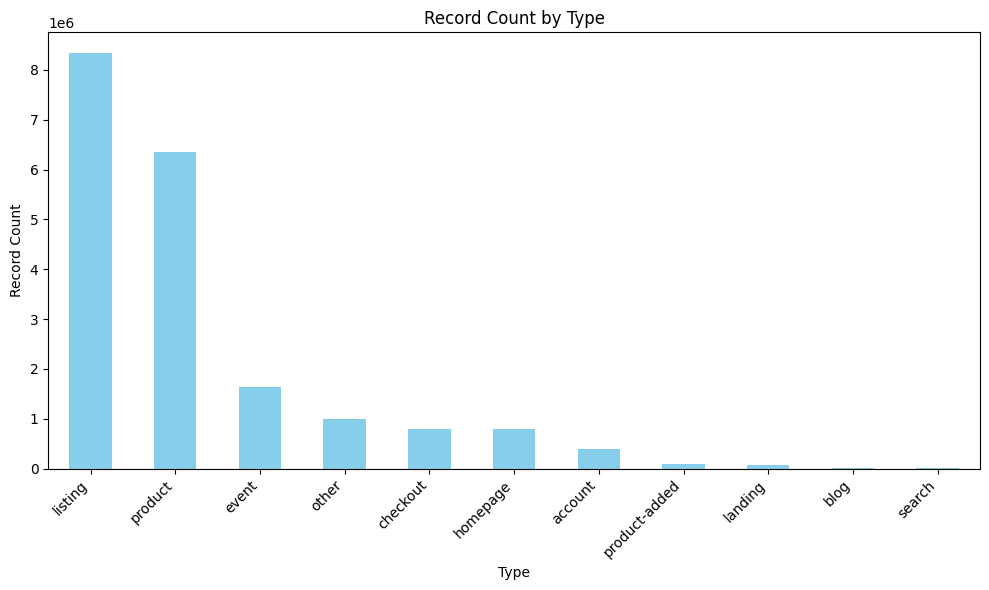

In [7]:
# Group by 'type' and count occurrences
type_counts = df.groupBy("type").count().orderBy("count", ascending=False)

# Plot the bar chart
type_counts_pd = type_counts.toPandas()

type_counts_pd.plot(
    x="type",
    y="count",
    kind="bar",
    figsize=(10, 6),
    legend=False,
    color="skyblue",
    title="Record Count by Type"
)

plt.xlabel("Type")
plt.ylabel("Record Count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


# Sampling and Processing VisitKey  
This section filters the dataset for `listing` and `product` types, randomly samples 1000 rows, and processes the `visitKey` column to extract its parts (`part_2`, `part_3`, `part_4`).  


In [8]:
# Filter dataset for 'listing' and 'product' types
filtered_df = df.filter(col("type").isin("listing", "product"))

# random sample of 1000 rows
sample_df = filtered_df.sample(withReplacement=False, fraction=0.005, seed=random.randint(0, 1000))
sample_df = sample_df.limit(1000)  # Ensure exactly 1000 rows

# Split visitKey
split_col = split(col("visitKey"), "-")

# Process the visitKey
processed_sample_df = sample_df.withColumn(
    "part_2",
    when(
        col("type") == "listing",
        when(split_col[2].like("page%"), split_col[1]).otherwise(split_col[1])
    ).when(
        col("type") == "product",
        split_col[1]
    )
).withColumn(
    "part_3",
    when(
        col("type") == "listing",
        when(split_col[2].like("page%"), lit(None)).otherwise(split_col[2])
    ).when(
        col("type") == "product",
        split_col[2]
    )
).withColumn(
    "part_4",
    when(
        col("type") == "listing",
        when(split_col[2].like("page%"), lit(None)).otherwise(
            when(split_col[3].like("page%"), lit(None)).otherwise(split_col[3])
        )
    ).when(
        col("type") == "product",
        split_col[3]
    )
)

# Select relevant columns to show
processed_sample_df = processed_sample_df.select("type", "url", "visitKey", "part_2", "part_3", "part_4")

processed_sample_df.show(100, truncate=False)


+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------+-----------+-----------+---------+
|type   |url                                                                                                                                                             |visitKey                                                                     |part_2     |part_3     |part_4   |
+-------+----------------------------------------------------------------------------------------------------------------------------------------------------------------+-----------------------------------------------------------------------------+-----------+-----------+---------+
|product|https://4fstore.lv/unisex-adas-apavi-lifestyle-sneakers-4f-x-robert-lewandowski-rl9s23flowu018-23s.html                                       

# Data Cleaning and VisitKey Processing  
This part focuses on cleaning the dataset by:  
- Removing rows with missing or invalid `userId` values.  
- Extracting meaningful parts (`visitKey_part2` and `visitKey_part3`) from the `visitKey` column based on type (`listing` or `product`).  
- Normalizing `visitKey_part2` by replacing terms with limited utility (e.g., `Cart`, `ProductPage`, `Search`, etc.) and invalid patterns (e.g., containing 3+ digits) with "unknown".  
- Ensuring missing values are handled appropriately.  
- Filtering the dataset to retain only `listing` and `product` types for further analysis.  


In [5]:
# Filter out rows where userId is NULL or '---'
cleaned_df = df.filter(
    (col("userId").isNotNull()) & (col("userId") != "---")
)

# Split visitKey into parts
split_col = split(col("visitKey"), "-")

# Extract visitKey_part2 and visitKey_part3 based on type and specific patterns
cleaned_df = cleaned_df.withColumn(
    "visitKey_part2",
    when(
        col("type") == "listing",
        when(split_col[2].like("page%"), split_col[1]).otherwise(split_col[1])
    ).when(
        col("type") == "product",
        split_col[1]
    ).otherwise(lit(None))  # Set to NULL for other types
).withColumn(
    "visitKey_part3",
    when(
        col("type") == "listing",
        when(split_col[2].like("page%"), lit(None)).otherwise(split_col[2])
    ).when(
        col("type") == "product",
        split_col[2]
    ).otherwise(lit(None))  # Set to NULL for other types
)

# Replace invalid visitKey_part2 values with 'unknown' if they contain 3 or more digits
cleaned_df = cleaned_df.withColumn(
    "visitKey_part2",
    when(
        regexp_extract(col("visitKey_part2"), r"(\d.*\d.*\d)", 0) != "", "unknown"
    ).otherwise(col("visitKey_part2"))
)

# Replace special terms like 'Cart', 'ProductPage', 'Search' with 'unknown' in visitKey_part2
# as they are useless information
special_terms = ["Cart", "ProductPage", "Search", "4f", "4fpro"]
cleaned_df = cleaned_df.withColumn(
    "visitKey_part2",
    when(
        col("visitKey_part2").isin(special_terms), "unknown"
    ).otherwise(col("visitKey_part2"))
)

# Handle missing values in visitKey_part2 and visitKey_part3
cleaned_df = cleaned_df.fillna({'visitKey_part2': 'unknown', 'visitKey_part3': 'unknown'})

# Filter only rows where type is 'listing' or 'product' for further processing
cleaned_df = cleaned_df.filter(col("type").isin("listing", "product"))

# Display the cleaned data for verification
cleaned_df.show(20, truncate=False)


+--------+----------------+----------------------------------------------------------------+------+------------------------------------+----------------------------------------------------------------------------------------------------------------------------------------------------------+-------+---------------------------------+--------+------+----+-------------------+--------------------------------------------------------------------------+-----------+--------------+--------------+
|token   |fingerprint     |userToken                                                       |siteId|userId                              |url                                                                                                                                                       |type   |group                            |category|action|name|time               |visitKey                                                                  |groupSource|visitKey_part2|visitKey_part3|
+--------+------

# User Clustering with KMeans  
This section covers the application of KMeans clustering to group users based on their behavioral patterns.  

## Feature Engineering  
1. Calculating total visits for each user.  
2. Extracting the top 3 most frequent `visitKey_part2` values per user and pivoting them to create user-interest features.  
3. Adding additional features such as counts of `listing` and `product` visits.  
4. Combining these features into a single feature vector for clustering.  

## Clustering Users  
- KMeans clustering is applied to the engineered features to segment users into four distinct groups.  
- The optimal number of clusters (`k=4`) was determined based on prior evaluations.  
- A silhouette score is calculated to evaluate clustering quality.  

## Cluster Evaluation and Visualization  
- The distribution of users across clusters is displayed, along with sample user data for verification.  
- PCA is used to reduce features to 2D for visualization.  
- A scatter plot illustrates the user distribution across clusters, providing insights into behavioral segmentation.  


Silhouette Score: 0.8402057756055178
+----------+----------+
|prediction|user_count|
+----------+----------+
|         1|      4392|
|         3|     27427|
|         2|       310|
|         0|    216844|
+----------+----------+

+------------------------------------+-----------------------------------------------------------+----------+
|userId                              |features                                                   |prediction|
+------------------------------------+-----------------------------------------------------------+----------+
|00008263-685b-4bf3-8fe5-b1a32f10bbf7|(185,[0,70,173,174,183,184],[39.0,6.0,12.0,21.0,18.0,21.0])|0         |
|0004cc00-a50b-433c-968a-1afae18f0532|(185,[0,179,184],[3.0,3.0,3.0])                            |0         |
|0004e3af-561f-40ec-8190-7a91b887bb5c|(185,[0,70,183],[3.0,3.0,3.0])                             |0         |
|000577ad-7d7e-48da-bb16-7c6cfcba5e8d|(185,[0,61,174,179,183,184],[46.0,9.0,27.0,6.0,13.0,33.0]) |0         |


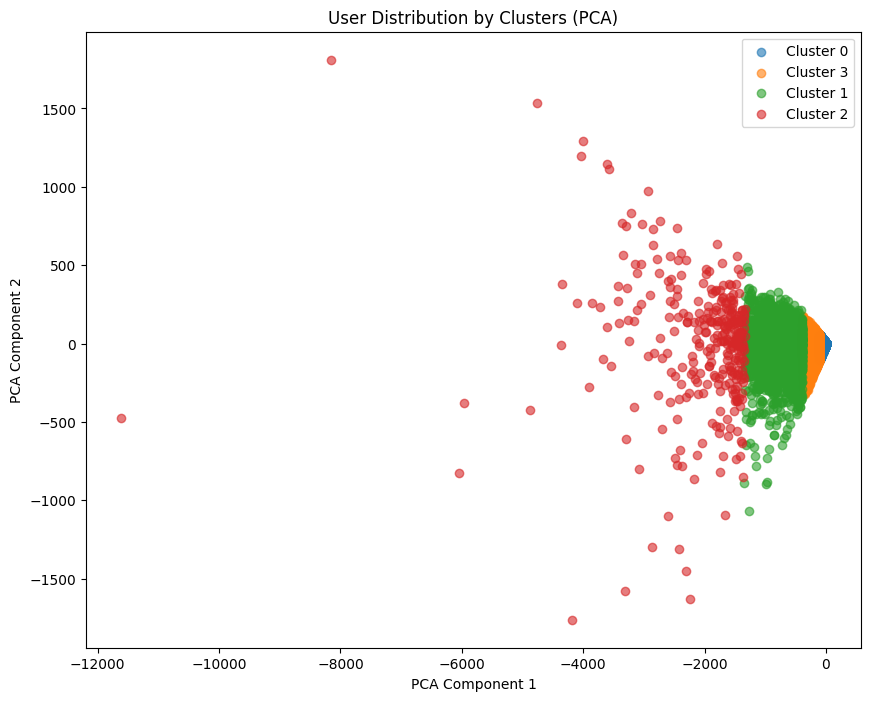

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Calculate total visits for each user
user_visits = cleaned_df.groupBy("userId").agg(count("*").alias("visit_count"))

# Filter out 'unknown' and calculate top 3 frequent visitKey_part2 values for each user
filtered_interests = cleaned_df.filter(
    (col("visitKey_part2") != "unknown") & col("visitKey_part2").isNotNull()
)
user_interests = filtered_interests.groupBy("userId", "visitKey_part2").count()

# Rank visitKey_part2 by frequency for each user
window = Window.partitionBy("userId").orderBy(col("count").desc())
ranked_interests = user_interests.withColumn("rank", row_number().over(window))

# Keep only the top 3 visitKey_part2 for each user
top_interests = ranked_interests.filter(col("rank") <= 3)

# Pivot the top interests to create user-interest features
interests_pivoted_top = (
    top_interests.groupBy("userId").pivot("visitKey_part2").sum("count").fillna(0)
)

# Add listing and product visit counts
listing_visits = (
    cleaned_df.filter(col("type") == "listing")
    .groupBy("userId")
    .agg(count("*").alias("listing_count"))
)
product_visits = (
    cleaned_df.filter(col("type") == "product")
    .groupBy("userId")
    .agg(count("*").alias("product_count"))
)

# Combine all selected features into a single DataFrame
final_features = (
    user_visits.join(interests_pivoted_top, on="userId", how="left")
    .join(listing_visits, on="userId", how="left")
    .join(product_visits, on="userId", how="left")
    .fillna(0)
)

# Assemble features for KMeans
feature_columns = (
    ["visit_count"]
    + [col for col in interests_pivoted_top.columns if col != "userId"]
    + ["listing_count", "product_count"]
)
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
kmeans_data = assembler.transform(final_features)

# Perform KMeans clustering
kmeans = KMeans(featuresCol="features", k=4, seed=42)  # Adjust k as needed
model = kmeans.fit(kmeans_data)
clustered_data = model.transform(kmeans_data)

# Evaluate clustering
evaluator = ClusteringEvaluator(featuresCol="features")
silhouette = evaluator.evaluate(clustered_data)
print(f"Silhouette Score: {silhouette}")

# Show cluster counts
cluster_counts = clustered_data.groupBy("prediction").agg(count("userId").alias("user_count"))
cluster_counts.show()

# Display sample user data with clusters
clustered_data.select("userId", "features", "prediction").show(10, truncate=False)


# column names
print("Clustered DataFrame Columns: ", clustered_data.columns)

# Reduce features to 2D using PCA for visualization
pca = PCA(k=2, inputCol="features", outputCol="pca_features")
pca_model = pca.fit(kmeans_data)  # Use the final kmeans_data DataFrame
pca_data = pca_model.transform(clustered_data)

# Convert PCA results
pca_result = pca_data.select("pca_features", "prediction").toPandas()
pca_result["pca_x"] = pca_result["pca_features"].apply(lambda x: x[0])  # First component
pca_result["pca_y"] = pca_result["pca_features"].apply(lambda x: x[1])  # Second component
pca_result["cluster"] = pca_result["prediction"]

# Plot the 2D scatter plot
plt.figure(figsize=(10, 8))
for cluster in pca_result["cluster"].unique():
    cluster_data = pca_result[pca_result["cluster"] == cluster]
    plt.scatter(cluster_data["pca_x"], cluster_data["pca_y"], label=f"Cluster {cluster}", alpha=0.6)

plt.title("User Distribution by Clusters (PCA)")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend()
plt.show()

# Saving and Downloading User Cluster Results  
This section focuses on exporting the clustering results for further analysis or sharing.

## Saving Cluster Data to CSV  
- Extracts `userId` and their corresponding cluster `prediction` from the clustered DataFrame.  
- Converts the Spark DataFrame to a Pandas DataFrame for compatibility with CSV export.  
- Saves the data to a CSV file named `user_clusters.csv`.  

## Downloading the CSV File  
- Utilizes Colab's `files.download()` method to make the saved file easily accessible for download.  


In [ ]:
# Save user clusters to a CSV file
user_cluster_data = clustered_data.select("userId", "prediction")
user_cluster_df = user_cluster_data.toPandas()
file_name = "user_clusters.csv"
user_cluster_df.to_csv(file_name, index=False)

# Provide a download link for the saved file in Colab
files.download(file_name)